In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [9]:
BASE_DIRECTORY = "faces"

def process_data():
    image_data = []
    targets = []

    for i, folder in enumerate(os.listdir(BASE_DIRECTORY)):
        folder_path = os.path.join(BASE_DIRECTORY, folder)
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            with Image.open(image_path) as img:
                img = img.resize((150, 150))
                img_array = np.array(img)
                image_data.append(img_array)
                targets.append(i)
    
    image_data = np.array(image_data)
    targets = np.array(targets)

    train_data, test_data, train_label, test_label = [], [], [], []

    for person in range(15):
        person_indices = np.where(targets == person)[0]
        train_indices = person_indices[3: 11]
        test_indices = person_indices[:3]
        train_data.extend(image_data[train_indices])
        train_label.extend(targets[train_indices])
        test_data.extend(image_data[test_indices])
        test_label.extend(targets[test_indices])
    
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data)
    test_label = np.array(test_label)
    
    return train_data, train_label, test_data, test_label

train_data, train_label, test_data, test_label = process_data()
print("Training Data set", train_data,"\n, Training Labels", train_label)

print("Testing Data set", test_data, "\n, Testing Labels", test_label)


Training Data set [[[179 179 179 ... 220 210 232]
  [255 255 255 ... 208 220 228]
  [254 254 254 ... 203 217 226]
  ...
  [255 255 255 ... 192 184 176]
  [255 255 255 ... 193 198 204]
  [141 141 141 ... 117 118 122]]

 [[179 179 179 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [254 254 254 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 254]
  [255 255 255 ... 255 255 255]
  [141 141 141 ... 141 141 141]]

 [[179 179 179 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [254 254 254 ... 255 255 255]
  ...
  [255 255 255 ... 255 254 252]
  [255 255 255 ... 255 255 255]
  [141 141 141 ... 141 141 141]]

 ...

 [[179 179 179 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [254 254 254 ... 255 255 255]
  ...
  [255 255 255 ... 245 230 240]
  [255 255 255 ... 233 255 255]
  [141 141 141 ... 132 143 144]]

 [[179 179 179 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [254 254 254 ... 255 255 255]
  ...
  [255 255 255 ... 236 218 232]
  [255 255 255 ... 226 247 249]
  [141 141

The Data set is now divided into Training data set and  Testing Data set with their corresponding label or class.

In [4]:
def EuclideanDistance(p, q):
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return np.sqrt(np.sum(np.power((p - q), 2)))

In [5]:
  
def project( W, train_data, mu = None):
        if mu is None:
            return np.dot(train_data, W)
        return np.dot(train_data - mu, W)
    
def reconstruct( W, Y, mu = None):
        if mu is None:
            return np.dot(Y, W.T)
        return np.dot(Y, W.T) + mu
    
def pca( train_data, train_label, num_components = 0):
        [n, d] = train_data.shape

        if (num_components <= 0) or (num_components > n):
            num_components = n
        
        mu = train_data.mean(axis = 0)
        train_data = train_data - mu

        if n > d:
             C= np.dot(train_data.T, train_data)
             [eigenvalues, eigenvectors] = np.linalg.eigh(C)
        else:
            C = np.dot(train_data, train_data.T)
            [eigenvalues, eigenvectors] = np.linalg.eigh(C)
            eigenvectors = np.dot(train_data.T, eigenvectors)

            for i in range(n):
                eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])
            
            idx = np.argsort(-eigenvalues)
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]

            eigenvalues = eigenvalues[0: num_components].copy()
            eigenvectors = eigenvectors[:, 0: num_components].copy()

        return [eigenvalues, eigenvectors, mu]
    
def lda( train_data, train_label, num_components = 0):
        [n,d] = train_data.shape

        c = np.unique(train_label)

        if (num_components <= 0) or (num_components > (len(c) - 1)):
            num_components = len(c) - 1
        
        meanTotal = train_data.mean(axis = 0)

        Sw = np.zeros((d, d), dtype = np.float32)
        Sb = np.zeros((d, d), dtype = np.float32)

        for i in c:
            train_datai = train_data[np.where(train_label == i)[0], :]
            meanClass = train_datai.mean(axis = 0)
            Sw = Sw + np.dot((train_datai - meanClass).T, (train_datai - meanClass))
            Sb = Sb + n * np.dot((meanClass - meanTotal), (meanClass - meanTotal).T)

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) * Sb)
        idx = np.argsort(-eigenvalues.real)

        eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]

        eigenvalues = np.array(
            eigenvalues[0: num_components].real, dtype = np.float32, copy = True
        )

        eigenvectors = np.array(
            eigenvectors[0:, 0:num_components].real, dtype = np.float32, copy = True
        )

        return [eigenvalues, eigenvectors]
    
def fisherfaces( train_data,train_label, num_components = 0):

        n = train_data.shape[0]

        c = len(np.unique(train_label))
        [eigenvalues_pca, eigenvectors_pca, mu_pca] = pca(train_data, train_label, n - c)

        [eigenvalues_lda, eigenvectors_lda] = lda(project(eigenvectors_pca, train_data, mu_pca), train_label, num_components)

        eigenvectors = np.dot(eigenvectors_pca, eigenvectors_lda)

        return [eigenvalues_lda, eigenvectors, mu_pca]
    
def create_font( fontname = "Arial", fontsize = 10):
        return {"fontname": fontname, "fontsize": fontsize}
    
def normalize( x, low, high, dtype = None):
        minx, marx = np.min(x), np.max(x)

        x = x - float(minx)
        x = x / float((marx - minx))
        x = x * (high - low)
        x = x + low

        if dtype is None:
            return np.asarray(x)
        return np.asarray(x, dtype = None)
    
def asRowMatrix( X):
        if len(X) == 0:
            return np.array([])
        mat = np.empty((0,X[0].size), dtype = X[0].dtype)

        for row in X:
            mat = np.vstack((mat, np.asarray(row).reshape(1, -1)))
        
        return mat
def subplot(
            title,
            images,
            rows,
            cols,
            sptitle = "subplot",
            sptitles = [], 
            colormap = cm.gray,
            ticks_visible = True,
            filename = None
    ):
        fig = plt.figure()
        fig.text(0.5, 0.95,title, horizontalalignment = "center")
        
        for i in range(len(images)):
            ax0 = fig.add_subplot(rows, cols, (i + 1))
            plt.setp(ax0.get_xticklabels(), visible = False)
            plt.setp(ax0.get_yticklabels(), visible = False)

            if len(sptitles) == len(images):
                plt.title(
                    "%s #%s" % (sptitle, str(sptitles[i])),
                    create_font("Tahoma", 10),
                ) 
            else:
                plt.title("%s #%d" % (sptitle, (i + 1)), create_font("Tahoma",10))
            plt.imshow(np.asarray(images[i]), cmap = colormap)
        
        if filename is None:
            plt.show()
        
        else:
            fig.savefig(filename)
                   

The reconstructed images are as Follow.

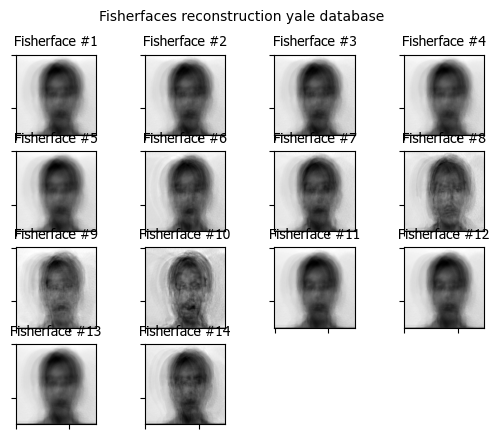

In [6]:
[D, W, mu] = fisherfaces(asRowMatrix(train_data), train_label)

E = []

for i in range(min(W.shape[1], 16)):
    e = W[:, i].reshape(-1, 1)
    p = project(e, train_data[0].reshape(1, -1), mu)
    R = reconstruct(e, p, mu)
    R = R.reshape(train_data[0].shape)
    E.append(normalize(R, 0, 255))

subplot(
    title = "Fisherfaces reconstruction yale database",
    images = E,
    rows = 4,
    cols = 4,
    sptitle = "Fisherface",
    colormap = cm.gray,
)

Now We can proceed to predicting function.

In [7]:
def compute(X, y):
    projections = []
    [D, W, mu]  = fisherfaces(asRowMatrix(X), y, num_components = 0)
    for xi in X:
        projections.append(project(W, xi.reshape(1, -1), mu))
    return projections

def predict(test_data):
    projections = compute(train_data, train_label)
    
    minDist = np.finfo("float").max
    minClass = -1

    Q = project(W, test_data.reshape(1, -1), mu)

    for i in range(len(projections)):
        dist = EuclideanDistance(projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = train_label[i]
    return minClass




Here we will predict the labels for the test data and calculate the performance of fisherface.

In [11]:
corrects = 0
total = 0
for index, test in enumerate(test_data):
    total += 1
    if test_label[index] == predict(test_data[index]):
        corrects += 1
    print("Expected = ", test_label[index], " /predicted = ", predict(test_data[index]))


print(f"The algorithm's accuracy is {(corrects / total) * 100}%")

Expected =  0  /predicted =  0
Expected =  0  /predicted =  0
Expected =  0  /predicted =  0
Expected =  1  /predicted =  1
Expected =  1  /predicted =  1
Expected =  1  /predicted =  1
Expected =  2  /predicted =  2
Expected =  2  /predicted =  2
Expected =  2  /predicted =  2
Expected =  3  /predicted =  3
Expected =  3  /predicted =  3
Expected =  3  /predicted =  3
Expected =  4  /predicted =  4
Expected =  4  /predicted =  4
Expected =  4  /predicted =  4
Expected =  5  /predicted =  5
Expected =  5  /predicted =  5
Expected =  5  /predicted =  5
Expected =  6  /predicted =  7
Expected =  6  /predicted =  6
Expected =  6  /predicted =  6
Expected =  7  /predicted =  7
Expected =  7  /predicted =  7
Expected =  7  /predicted =  7
Expected =  8  /predicted =  7
Expected =  8  /predicted =  7
Expected =  8  /predicted =  8
Expected =  9  /predicted =  9
Expected =  9  /predicted =  9
Expected =  9  /predicted =  9
Expected =  10  /predicted =  10
Expected =  10  /predicted =  10
Expe